In [1]:
import geopandas as gpd
import pandas as pd
import time
from sklearn.cluster import DBSCAN
from shapely.geometry import MultiPoint
from geopy.distance import great_circle

import geopandas as gpd
from shapely.geometry import LineString, Point
from geopy.distance import geodesic
import os
import numpy as np

## Load German Unfallatlas 

In [4]:
unfallorte = gpd.read_file('Files/Unfallorte2022/Unfallorte2022_LinRef.shp')

### Data Preparation
convert functions for datarame to int, float data types

In [5]:
def convert_int(value):
    try: 
        return int(value)
    except Exception:
        return np.nan

In [6]:
def convert_float(value):
    try: 
        return float(value)
    except ValueError:
        return np.nan

apply EPSG:4326

In [9]:
# convert geometries to EPSG:4326 crs
unfallorte = unfallorte.to_crs("EPSG:4326")

In [8]:
# convert relevant columns to INT type
columns_to_convert = ['IstPKW', 'UJAHR', 'IstFuss', 'UTYP1', 'ULICHTVERH']
unfallorte[columns_to_convert] = unfallorte[columns_to_convert].applymap(convert_int)

## Load OSM Highway data
Data was previously pulled from OSM via Overpass API

In [11]:
combined_gdf = gpd.read_file('Files/highways_DE_complete.shp')

## Define Map Matching Function Using Great Circle Distance 

In [22]:
# Function to compute closest OSM ID to a GPS Point
def closest_OSM_ID_index(random_point,combined_gdf):
    """
    Function to compute closest OSM ID to a GPS Point

    :param p1: GPS Point (here unfallatlas crash positions)
    :param p2: OSM Geopandas Datafram on whcih the data should be mapped on
    """
        
    min_distance = float('inf')  # Initialize with positive infinity
    nearest_osm_id = None
    nearest_ref = None
    nearest_line = None
    
    possible_matches_index = list(combined_gdf.sindex.intersection(random_point.bounds))
    
    # Iterate through the candidate rows in the GeoDataFrame
    for idx in possible_matches_index:
        row = combined_gdf.iloc[idx]
        line = row['geometry']

        # Calculate the minimum Haversine distance between each coordinate point in the LineString and the random_point 
        line_distance = min(
            geodesic((point[1], point[0]), (random_point.y, random_point.x)).meters
            for point in line.coords
        )

        # Check if this row has a smaller distance than the current minimum
        if line_distance < min_distance:
            min_distance = line_distance
            nearest_osm_id = row['osm_id']
            nearest_ref = row['ref']
            nearest_line = line

    # Print the nearest LineString, associated "osm_id," and the Haversine distance
    print(f"Nearest OSM ID:{nearest_osm_id}, nearest ref:{nearest_ref}")
    print("Haversine Distance (meters):", min_distance)
    return nearest_osm_id, min_distance, nearest_ref

##  Compute closest OSM Road Segments of each Crash GPS Coordinate

In [ ]:
# apply closest_OSM_ID_index to unfallorte GeoPandas df
results = unfallorte.apply(lambda row: closest_OSM_ID_index(row["geometry"], combined_gdf), axis=1)

# Create two separate lists to hold the results
osm_ids, distances, ref = zip(*results)

# Add the lists as new columns to the points_in_berlin DataFrame
unfallorte['osm_id'] = osm_ids
unfallorte['distance'] = distances
unfallorte['ref'] = ref

In [24]:
# convert osm_id to type int
unfallorte['osm_id'] = unfallorte['osm_id'].apply(lambda x: convert_int(x))

<Axes: >

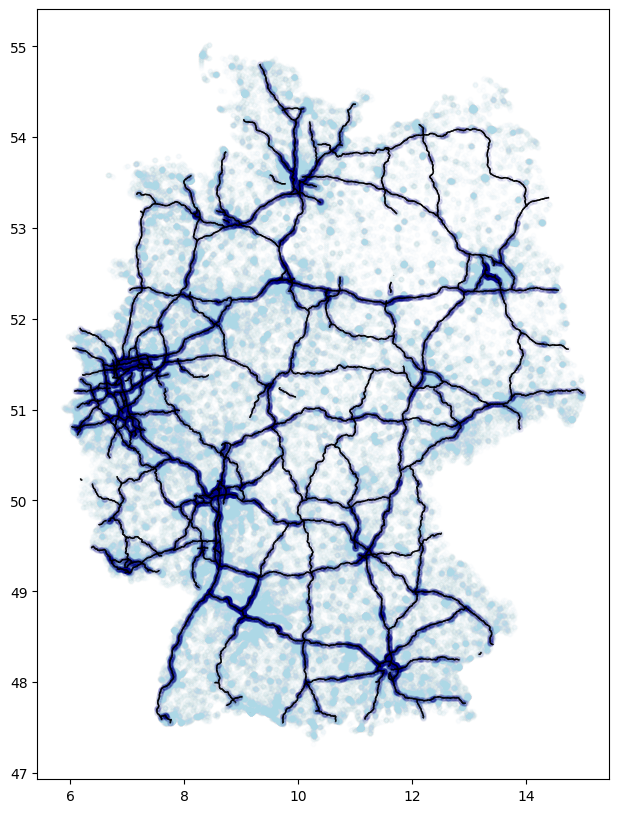

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(18, 10))

unfallorte[unfallorte["osm_id"].isna()].plot(ax=ax, markersize=10, alpha = 0.03, color="lightblue")
combined_gdf.plot(ax=ax, linewidth=1, color="black")
unfallorte[unfallorte["osm_id"]>0].plot(ax=ax, markersize=15, alpha = 0.05, color="darkblue")


In [26]:
unfallorte.to_file("unfallorte_2022_HW_mapmatched_ref.shp")